#**Lab 10 - Coreference Resolution**


In this lab, we are going to build a coreference system based on the mention-ranking algorithm proposed by Lee et al (2017).  You will get part of the code required to build the system, and you are required to fill three code blocks. Hints will be provided to guide you through. 

The first part of the notebook will show how to apply coreference resolution to English using a few examples. Then you have to apply that to Arabic.  

In total, you will be given one python file (*.py), three JSON files (*.jsonlines) and one embedding file (*.txt):

*   **metric.py**: is used to compute the CoNLL scores; you don’t need to change it.
*   **[train/test/dev].arabic.jsonlines** Arabic documents are the training, testing and development set will be used for training and evaluating the model, which are ready to use. 
*   **word_embeddings.filtered.txt** is pre-trained 300-dimensional FastText word embeddings. The original file is large, so we‘ve removed all the words that do not appear in the datasets to make it much smaller.

These files are contained in the folder coreference_files provided with the lab.



In [ ]:
#installing the correct scikit-learn lib
!pip install scikit-learn==0.22.2 --no-deps

     |████████████████████████████████| 7.1 MB 5.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


##**0. Download the files to google colab.**

First, we will download coreference resolution files to Colab so we can access the  dataset and the conll scorer.

**Important:**

The cells in this section might not work if you are working on your local machine. 

You might have to download the zip file and unzip it. 
The coref_files.zip link:

https://collect.qmul.ac.uk/down?t=5DBIRDID7VO84D2C/4P63FA4B9R6A4LLML77Q21O


In [ ]:
from google.colab import drive, output
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# #Extracting the coref_files.zip
# import zipfile, os
# path_to_zip_file = 'coref_files.zip'
# if(os.path.isdir('/content/coref_files')):
#     print('The coref files have been uploaded already')
# else:
#     print('Extracting the zip file.....')
#     with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#         zip_ref.extractall("/content/")

##**1. Add relevant paths**

Next, we will append the path to the google drive folder containing the forementioned files to google colab.



In [ ]:
# IMPORTANT change this to the path to your folder. Remember to start from the home directory, 'My Drive'
PATH_TO_FOLDER = "/content/drive/MyDrive/NN and NLP/Lab 10/coref_files/"

In [ ]:
import sys
sys.path.append(PATH_TO_FOLDER)

Now we can also add the paths to our dev/test/train files and our filtered embeddings


In [ ]:
DEV_PATH = PATH_TO_FOLDER + 'dev.arabic.jsonlines'
TEST_PATH = PATH_TO_FOLDER + 'test.arabic.jsonlines'
TRAIN_PATH = PATH_TO_FOLDER + 'train.arabic.jsonlines'

EMBEDDING_PATH = PATH_TO_FOLDER + 'word_embeddings.filtered.txt'


##**2. Import files**

We can now import metrics.py along with other python modules

In [ ]:
%%capture

from keras import Input,Model
from keras import backend as K
from keras.layers import Dropout,Dense,LSTM,Bidirectional,Lambda,Reshape
import numpy as np
import tensorflow as tf 
import random
import json,time,collections,random, metrics

#seed everything
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## **3. Creating an embedding dictionary**

Using the embedding file, we will create an embedding dictionary,
for easy access while preparing our data

In [ ]:
# the dimension of the pretrained embeddings
EMBEDDING_SIZE = 300

In [ ]:
def load_embeddings(embedding_path=EMBEDDING_PATH, embedding_size=EMBEDDING_SIZE):
    print("Loading word embeddings from {}...".format(embedding_path))
    embeddings = collections.defaultdict(lambda: np.zeros(embedding_size))
    for line in open(embedding_path):
        splitter = line.find(' ')
        emb = np.fromstring(line[splitter + 1:], np.float32, sep=' ')
        assert len(emb) == embedding_size
        embeddings[line[:splitter]] = emb
    print("Finished loading word embeddings")
    print("Number of words: " + str(len(embeddings)))
    return embeddings

In [ ]:
 EMBEDDING_DICT = load_embeddings() 

Loading word embeddings from /content/drive/MyDrive/NN and NLP/Lab 10/coref_files/word_embeddings.filtered.txt...
Finished loading word embeddings
Number of words: 26546


##**4. Preparing Documents for Coreference**

In this section,  we will show how to prepare the dataset for coreference resolution using a few examples in English. Then youwill have to prepare for the Arabic dataset in the jsonfiles.
<br>

Each line in a given json file contains information for a single document. The “doc_key” stores the name of the document; the “sentences” points you to tokenized sentences of the document; the “clusters” element stores the coreference clusters. Each of the clusters contains a number of mentions encoded, each of the mentions has a start and an end indices, denoting the position of its first token and the index its last token within the document. 
As an illustration, consider the dummy dataset in the block of code below containing one document. Run the code cell to see the clusters of coreferent mentions.


In [ ]:
dummy_dataset = [{'doc_key': 'large_cat',
                  'sentences':[['The', 'large', 'cat', 'yawned', '.'],
                               ['He','was', 'very', 'hungry', 'as', 'he', 'had', 'not', 'eaten', 'since', 'breakfast','.'],
                               ['An', 'unfortunate', 'rat', 'came', 'along', '.'],
                               ['The', 'cat', 'gobbled', 'him', 'up', '.']],
                  'clusters': [[[0, 2], [5, 5], [10, 10], [23, 24]], [[17, 19], [26, 26]]]
                }]


sents = [w for sent in dummy_dataset[0]['sentences'] for w in sent]
print('These are the clusters in %s' %dummy_dataset[0]['doc_key'])
for cl_idx, cl in enumerate(dummy_dataset[0]['clusters']):
    print('Cluster ' + str(cl_idx) + ':', [' '.join(sents[s: e+1])  for s, e in cl])

These are the clusters in large_cat
Cluster 0: ['The large cat', 'He', 'he', 'The cat']
Cluster 1: ['An unfortunate rat', 'him']


To prepare the each dataset for the coreference resolution model, we will need to create variables from the each document:

1.   Embedded Sentences: A 1 X num_sents X num_words X embedding size array for each document. 
2.   Mention Pairs: A 1 X num_pairs X 4 array like so [anaphor_start, anaphor_end, antecedent_start, antecedent_end]
3. Mention Pair Labels: A num_pairs X 1 array containing corresponding labels for each mention pair (i.e. 1 if the pair of mentions are coreferent, 0 otherwise). 

The functions that follow in the subsections below contains code for extracting this dataset. Study them and test their functionality using the dummy dataset.
In section 4.4, you'll use these functions to create the dev, test and train datasets.

###**4.1 Getting the mentions from the clusters**

The following block of code gets the mentions from a given cluster in a document. 

In [ ]:
def get_mentions(clusters):

    # get a list of mentions (as tuples) sorted by start indices.
    gold_mentions = sorted([tuple(m) for cl in clusters for m in cl])

    # number of mentions
    num_mentions = len(gold_mentions)

    # assign unique indices to each mention in the mention list based on its position in the list
    gold_mention_map = {m: i for i, m in enumerate(gold_mentions)}

    # assign cluster ids to each mention in order E.g. cluser_ids = [4, 11, 5, 4, ..] => mention 0 is in cluster 4
    # along with mention 3.
    cluster_ids = [0]*num_mentions
    for cid, cluster in enumerate(clusters):
        for mention in cluster:
            cluster_ids[gold_mention_map[tuple(mention)]] = cid

    return gold_mentions, gold_mention_map, cluster_ids, num_mentions


In [ ]:
dmentions, dment_map, dcluster_ids, dnum_mentions = get_mentions(dummy_dataset[0]['clusters'])
print('These are all the coreferent mentions in the sample document ', dmentions)
print('These are the mentions mapped to unique ids denoting their order in the document ', dment_map)
print('These are the cluster ids of the ordered mentions', dcluster_ids)
print('There are %d mentions in the document titled \'%s\'' %(dnum_mentions, dummy_dataset[0]['doc_key']))

These are all the coreferent mentions in the sample document  [(0, 2), (5, 5), (10, 10), (17, 19), (23, 24), (26, 26)]
These are the mentions mapped to unique ids denoting their order in the document  {(0, 2): 0, (5, 5): 1, (10, 10): 2, (17, 19): 3, (23, 24): 4, (26, 26): 5}
These are the cluster ids of the ordered mentions [0, 0, 0, 1, 0, 1]
There are 6 mentions in the document titled 'large_cat'


###**4.2 Turning the sentences into embeddings and the mention indices into vectors**

Using the next block of code, you can generate the padded document embeddings, and a copy of the mention starts and end indices adjusted for padding. 

In [ ]:


def tensorize_doc_sentences(sentences, mentions):
    starts, ends = [],[]
    sent_lengths = [len(sent) for sent in sentences]  # the actual, unpadded length of each sentence
    max_sent_length = max(sent_lengths)

    # by padding each sentence to the maximum length, the embedded document will a new dimension
    embedded_sentences = np.zeros([1, len(sentences), max_sent_length, EMBEDDING_SIZE])

    # in this block, we adjust the mention indices to reflect the added padding.
    sent_start = 0
    sent_start_after_padding = 0
    offset = 0
    for i, sent in enumerate(sentences):
        for m_start, m_end in mentions:
            if (sent_start <= m_start) & (m_end < sent_start + len(sent)):
                starts.append(m_start + offset)
                ends.append(m_end + offset)
        sent_start += len(sent)
        sent_start_after_padding += max_sent_length
        offset += max_sent_length - len(sent)

        # Populate the the embedding tensor with the appropriate word embeddings.
        for j, word in enumerate(sent):
                embedded_word = EMBEDDING_DICT[word]
                embedded_sentences[0, i, j] = embedded_word


    return embedded_sentences, starts, ends

In [ ]:
dsents_embedded, dstarts, dends = tensorize_doc_sentences(dummy_dataset[0]['sentences'], dmentions)

In [ ]:
print('%d document with %d sentences, each with a maximum of %d words, encoded as %d dimensional vectors' %(dsents_embedded.shape[0], dsents_embedded.shape[1], dsents_embedded.shape[2], dsents_embedded.shape[3])) 
print('Mention starts: ', dstarts)
print('Mention ends: ', dends)

1 document with 4 sentences, each with a maximum of 12 words, encoded as 300 dimensional vectors
Mention starts:  [0, 12, 17, 24, 36, 39]
Mention ends:  [2, 12, 17, 26, 37, 39]


###**4.3. Generating Mention Pairs**

This next function generates the example pairs for training or evaluation. For each mention (anaphor), candidate antecedents are any mentions preceeding it.

<br>

Here, during training we choose up to 250 antecedents (i.e. MAX_ANT = 250) and maintain a 2:1 negative to positive example ratio i.e. NEG_RATIO=2. (choosing this ratio can be challenging as you want ample examples to learn from but at the same time do not want the positive examples to be overshadowed by the negative ones).

<br>

At test time, we generate up to MAX_ANT examples without paying attention to the example ratio. We also do not generate training labels for the pairs.

In [ ]:
# the maximum number of candidate antecedents we will give to each of the candidate mentions.
MAX_ANT = 250

# the ratio of negative to postive examples
NEG_RATIO = 2



Study the function below and see the sample outputs.

In [ ]:
def generate_pairs(num_mentions, cluster_ids, starts, ends, raw_starts, raw_ends, is_training, neg_ratio=NEG_RATIO, max_ant=MAX_ANT):
    mention_pairs = [[]]
    mention_pair_labels = [[]]
    raw_mention_pairs = []

    # for the training set, we want labels. We also want to pay heed to the positive:negative example ratio
    if is_training:
        for ana in range(num_mentions):
            pos = 1
            # each anaphor must not have more that MAX_ANT candidate antecedents
            s = 0 if ana < max_ant else (ana - max_ant)
            for ant in range(s, ana):
                # two mentions are coreferent if they are in the same cluster
                l = cluster_ids[ana] == cluster_ids[ant]
                # if it's a positive example, add it
                if l:
                    pos += neg_ratio
                    mention_pairs[0].append([starts[ana],ends[ana],starts[ant],ends[ant]])
                    mention_pair_labels[0].append(1)
                # if it's a negative example, check that we don't already have twice as 
                # many negative examples as positive ones before adding it
                elif pos > 0:
                    pos -=1
                    mention_pairs[0].append([starts[ana],ends[ana],starts[ant],ends[ant]])
                    mention_pair_labels[0].append(0)

    # for the test set, add the pairs without balancing or labels
    else:
        for ana in range(num_mentions):
            s = 0 if ana < max_ant else (ana - max_ant)
            for ant in range(s,ana):
                mention_pairs[0].append([starts[ana], ends[ana], starts[ant], ends[ant]])
                # here we also add the original mention indices for unpadded evaluation.
                raw_mention_pairs.append([(raw_starts[ana], raw_ends[ana]), (raw_starts[ant], raw_ends[ant])])
    

    return mention_pairs, mention_pair_labels, raw_mention_pairs

In [ ]:
# A sample for training. Maximum of 4 antecedents per mention a 2:1 negative example ratio: positive example. No need to save the raw starts/ends
dmpairs, dpair_labels, draw_pairs = generate_pairs(dnum_mentions, dcluster_ids, dstarts, dends, None, None, True, 1, 4)

from tabulate import tabulate
print(tabulate(zip(dmpairs[0], dpair_labels[0]), headers=['Ana_Ant pair', 'Pair label (padded)', ]))

Ana_Ant pair        Pair label (padded)
----------------  ---------------------
[12, 12, 0, 2]                        1
[17, 17, 0, 2]                        1
[17, 17, 12, 12]                      1
[24, 26, 0, 2]                        0
[36, 37, 0, 2]                        1
[36, 37, 12, 12]                      1
[36, 37, 17, 17]                      1
[36, 37, 24, 26]                      0
[39, 39, 12, 12]                      0
[39, 39, 24, 26]                      1
[39, 39, 36, 37]                      0


In [ ]:
# A sample for evaluation. No labels necessary. Here we pair each mention with all its antecedents
draw_starts, draw_ends = zip(*dmentions)
dmpairs, dpair_labels, draw_pairs = generate_pairs(dnum_mentions, dcluster_ids, dstarts, dends, draw_starts, draw_ends, False)

from tabulate import tabulate
print(tabulate(zip(draw_pairs, dmpairs[0]), headers=['Ana_Ant pair (unpadded)', 'Ana_Ant pair (padded)', ]))

Ana_Ant pair (unpadded)    Ana_Ant pair (padded)
-------------------------  -----------------------
[(5, 5), (0, 2)]           [12, 12, 0, 2]
[(10, 10), (0, 2)]         [17, 17, 0, 2]
[(10, 10), (5, 5)]         [17, 17, 12, 12]
[(17, 19), (0, 2)]         [24, 26, 0, 2]
[(17, 19), (5, 5)]         [24, 26, 12, 12]
[(17, 19), (10, 10)]       [24, 26, 17, 17]
[(23, 24), (0, 2)]         [36, 37, 0, 2]
[(23, 24), (5, 5)]         [36, 37, 12, 12]
[(23, 24), (10, 10)]       [36, 37, 17, 17]
[(23, 24), (17, 19)]       [36, 37, 24, 26]
[(26, 26), (0, 2)]         [39, 39, 0, 2]
[(26, 26), (5, 5)]         [39, 39, 12, 12]
[(26, 26), (10, 10)]       [39, 39, 17, 17]
[(26, 26), (17, 19)]       [39, 39, 24, 26]
[(26, 26), (23, 24)]       [39, 39, 36, 37]


### **4.4. Preprocessing and loading the dataset**

Now, you will prepare the dataset for the coreference resolution model. Preprocessing step is an important step and depends on the target language. For Arabic, removing diacritics (accents that are written  above, below or on top of certain letters)may improve the overall performance.

In [ ]:
import re, json

def preprocess_arabic_text(text):
  #diacrtic unicodes are found using regular expressions
  diacritics_unicode = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  #the diacrtics are then removed
  text = re.sub(diacritics_unicode, "", text)
  return text

def get_data(json_file, is_training, preprocess_text):
    processed_docs = []

    for line in open(json_file):

      # read the document in
      doc = json.loads(line)
      
      # check that there are coreferent mentions in this document
      clusters = doc['clusters']

      sentences = doc['sentences']

      if(preprocess_text==True):
          preprocessed_sents = [[preprocess_arabic_text(t) for t in sent] for sent in sentences]
          doc['sentences'] = preprocessed_sents
      
      if len(clusters) == 0:
          continue

      #  get the mentions and their cluster information.
      gold_mentions, gold_mention_map, cluster_ids, num_mentions =  get_mentions(clusters) # TASK 1.1 YOUR CODE HERE

      # splits the mentions into two arrays, one representing the start indices, 
      # and the other for the end indices
      raw_starts , raw_ends = zip(*gold_mentions)

      # pad sentences, create glove sentence embeddings, create mention starts and ends for padded document
      word_emb, starts, ends = tensorize_doc_sentences(doc['sentences'], gold_mentions) # TASK 1.2 YOUR CODE HERE
      # generate (anaphor, antecedent) pairs and their labels
      mention_pairs, mention_pair_labels, raw_mention_pairs = generate_pairs(num_mentions, cluster_ids, starts, ends, raw_starts, raw_ends, is_training,  neg_ratio=NEG_RATIO, max_ant=MAX_ANT) # TASK 1.3 YOUR CODE HERE
      mention_pairs, mention_pair_labels = np.array(mention_pairs),np.array(mention_pair_labels)

      # add the processed document to the list
      processed_docs.append((word_emb, mention_pairs, mention_pair_labels, clusters, raw_mention_pairs))

    return processed_docs


    

In [ ]:
# get_data(json_file, is_training_preprocess_text) receives three inputs: 
# json_file (str) : the path to json file, preprocess_text)
# is_training (boolean): this is used to with generate_pairs(...) function to balance the number of generated pairs
# preprocess_text (boolean): whether to preprocess text or not 

DEV_DATA = get_data(DEV_PATH, False, True)
TEST_DATA = get_data(TEST_PATH, False, True)
TRAIN_DATA = get_data(TRAIN_PATH, True, True)

##**5. Building the Coreference Model**

In this section, we will build the coreference resolution model. There are many ways to learn coreference, in this lab, we will be building a simplified version of a mention pair classification model. 

<br>

Given a pair of mentions, (anaphor, antecedent), a mention pair classifier produces a single score between 0 and 1, representing the probability that the given pair is coreferent. We will use keras to take in the processed data we prepared in section 4 and produce mention pair scores for the given pairs.

###**5.1 First, we will initialize model parameters.**

In [ ]:
# the dimension of the pretrained embeddings
EMBEDDING_SIZE = 300

# dropout rate for word embeddings
EMBEDDING_DROPOUT_RATE = 0.5

# the size of the hidden layer, include both LSTM and feedforward NN
HIDDEN_SIZE = 50

# the number of hidden layers used for the feedforward NN
NUM_FFN_LAYER = 2

# the dropout rate for the hidden layers of LSTM and feedforward NN
HIDDEN_DROPOUT_RATE = 0.2


###**5.2 Building the model**

In the next cell block, you will complete the build function by doing completing the steps that follow.

1. **Initialize the model inputs**

(a.) Using the keras input layer (already imported) initialize the two input layers
 `word_embeddings` and `mention_pairs`.
 
**Hints:**
*  The dimension for this input is `(batch_size X num_sents X num_words X embedding_size)` where batch_size is the number of inputs at each time step. Our batch size is 1 document.
*  As always, we do not need to specify the batch_size to the model (i.e. the first dimension is not included in the `shape` parameter of `Input()`.
*  The shape parameter is thus a tuple of 3 elements `(num_sents, num_words, embedding_size)`. The first two parameters vary accross documents but no matter, keras can infer them. You only need to specify the third (-1) element in the tuple.
*  The dimension for this input is  `(batch_size X num_mention_pairs  X 4)`.

    A line of code has been written for you to squeeze the word_embeddings after they have been created to remove the document dimension as the LSTMs only take 3 dimensional inputs

    `word_embeddings_no_batch = Lambda(lambda x: K.squeeze(x,0))(word_embeddings)`

    <br>

(b.) Apply `EMBEDDING_DROPOUT_RATE` dropout to this no-batch word embeddings

<br>

2. **Encode the document using Bidirectional LSTMs**


For task 1 we will be working at the beginning of the build() method. The task is to create a bidirectional LSTM to encode the sentences from both directions, which provides context information to the coreference system.

**Hints:**
* You'll need:
The dropout rate  of the hidden layers: `HIDDEN_DROPOUT_RATE`
The size of the lstm hidden layers: `HIDDEN_SIZE`

* You need to create a two layer bidirectional LSTM (BiLSTMs) by stacking two LSTM() layers wrapped with Bidirectional() layers. The BiLSTMs need to return the output for all the tokens in the sentences, not just the final one. The output of the BiLSTMs should be called word_output. Here is an example of how to create a BiLSTMs using keras: https://keras.io/examples/imdb_bidirectional_lstm/.

* Inorder to return the output for all the tokens in the sentences, i.e. a `(num_sents X num_words X HIDDEN_SIZE)` tensor, you will need to set the return_sequences attribute to True. The default setting is to return only the final output of the LSTM. And don’t forget to apply the recurrent_dropout.

<br>

We then flatten the output of the lstms to get a `(num_sents*num_words X HIDDEN_SIZE)` tensor using the Lambda function. This will help us gather the right indices for the mention pairs. We also apply further dropout.

`flatten_word_output = Lambda(lambda x:K.reshape(x, [-1, 2 * HIDDEN_SIZE]))(word_output)`

`flatten_word_output = Dropout(HIDDEN_DROPOUT_RATE)(flatten_word_output)`


<br>

Then, we get the mention pair representations by first collecting the learned embeddings for each the words represented by [anaphor_start, anaphor_end, antecedent_start, antecedent_end] for each pair. We retain the document dimension (i.e. batch_size) for this input.

`mention_pair_emb = Lambda(lambda x: K.gather(x[0], x[1]))([flatten_word_output, mention_pairs])`

Then concatenating the embeddings such that each mention pair is represented by a `4 X HIDDEN_SIZE` tensor.

`ffnn_input = Reshape((-1,8*HIDDEN_SIZE))(mention_pair_emb)`

`ffnn_input` is thus a `batch_size X num_mention_pairs X 400` tensor

<br>

3. **Create a multilayer feed-forward neural network to compute the mention-pair scores.**

Then you are required to create a FFNN that contains 2 hidden layers and an output layer. The outputs of the FFNN are  mention_pair_scores. Here are some requirements:

The hidden layers need to have a size of `HIDDEN_SIZE`
You need to apply dropout after each the hidden layers (but not the output layer). The outputs are called mention_pair_scores

**Hint:** 

Each hidden layer of the FFNN is a simple Dense() with an relu activation function. Layers are simply stacked together the output of the previous layer is the input for the next layer. To apply the dropout you can simply use the Dropout() layer. The output layer is slightly different, since it will have an output size of 1. Also in order to compute the binary cross entropy loss we need to give this final layer a sigmoid activation function.

After computing the mention_pair_scores you will need to remove the last dimension of it, since the last dimension is always 1. But be careful this time we will need to retain the batch dimension (for compute the loss and training accuracy). Again you can use the K.squeeze() method wrapped with a Lambda layer.
The final output `mention_pair_scores` should be a `batch_size X num_mention_pairs` tensor.


In [ ]:
# l = []
# for i in TRAIN_DATA:
#   l.append(i[5])
# num_mention_pairs = len(l)
# num_mention_pairs

In [ ]:
def build_model():
    # 1 (a.) Initialize the model inputs
    word_embeddings = Input(shape=(None,None,EMBEDDING_SIZE)) # YOUR CODE HERE
    
    mention_pairs = Input(shape=(None,4)) # TASK 2.1a YOUR CODE HERE

    # squeeze the (batch_size X num_sents X num_words X embedding_size) into a 
    # (num_sents X num_words X embedding_size) tensor
    word_embeddings_no_batch = Lambda(lambda x: K.squeeze(x,0))(word_embeddings)

    # 1 (b.). Apply embedding dropout to the squeezed embeddings.
    word_embeddings_dropped = Dropout(EMBEDDING_DROPOUT_RATE)(word_embeddings_no_batch) # TASK 2.1b YOUR CODE HERE

    # TASK 2.2. YOU CREATE A TWO LAYER BIDIRECTIONAL LSTM
    lstm1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, recurrent_dropout=HIDDEN_DROPOUT_RATE))(word_embeddings_dropped)
    word_output = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, recurrent_dropout=HIDDEN_DROPOUT_RATE))(lstm1)
    # word_output = Dropout(HIDDEN_DROPOUT_RATE)(lstm2)

    # flattening the lstms output and apply dropout.
    flatten_word_output = Lambda(lambda x:K.reshape(x, [-1, 2 * HIDDEN_SIZE]))(word_output)
    flatten_word_output = Dropout(HIDDEN_DROPOUT_RATE)(flatten_word_output)

    # we gather the embeddings represented by [anaphor_start, anaphor_end, antecedent_start, antecedent_end] for each pair.
    mention_pair_emb = Lambda(lambda x: K.gather(x[0], K.cast(x[1],dtype='int64')))([flatten_word_output, mention_pairs])

    # we flatten them such that each mention_pair is represented by a 400D tensor.
    ffnn_input = Reshape((-1,8*HIDDEN_SIZE))(mention_pair_emb)

    # TASK 2.3. CREATE THE MULTILAYER PERCEPTRONS THEN SQUEEZE OUT THE LAST DIMENSION USING LAMBDA 
    hd1 = Dense(HIDDEN_SIZE, activation='relu')(ffnn_input)
    hd1 = Dropout(HIDDEN_DROPOUT_RATE)(hd1)
    hd2 = Dense(HIDDEN_SIZE, activation='relu')(hd1)
    hd2 = Dropout(HIDDEN_DROPOUT_RATE)(hd2)
    mention_pair_scores = Dense(1, activation='sigmoid')(hd2)
    final_out = Lambda(lambda x: K.squeeze(x,-1))(mention_pair_scores)

    model = Model(inputs=[word_embeddings,mention_pairs], outputs=final_out)
    model.compile(optimizer='adam',loss='binary_crossentropy')
    print(model.summary())
    return model

In [ ]:
model = build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 300)]                                                            
                                                                                                  
 lambda (Lambda)                (None, None, 300)    0           ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, None, 300)    0           ['lambda[0][0]']                 
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 100)    140400      ['dropout[0][0]']            

##**6. Coreference Resolution Evaluation**

Coreference Resolution models are not evaluated using regular accuracy or f1 as one would evaluate a text classification model. Rather, using the pairwise scores produced by the system, we build coreference clusters. These clusters are
then evaluated using the CONLL score https://www.aclweb.org/anthology/W12-4501/ 
In this section, we build functions to build such clusters.

###**6.1 Getting the Predicted clusters**

First, we will write a function that takes a pair of mentions and produces two variables:

1. `predicted_clusters`: a list of tuples. Each tuple is a cluster (i.e. the elements of each tuple are the mentions predicted to belong to that cluster, where each mention is a (start_index, end_index) tuple.

2. `mention_to_predicted`: a dictionary whose keys are mentions and whose values are predicted clusters for the given mention

The input to the function `mention_pairs` is the list of predicted mention pairs
[[(anaphor_start, anaphor_end), (antecedent_start, antecedent_end)], ...] similar to draw_pairs in section 4.

In [ ]:
def get_predicted_clusters(mention_pairs):
    mention_to_predicted = {}
    predicted_clusters = []
    
    # for each mention and its predicted antecedent
    for anaphora, predicted_antecedent in mention_pairs:
        # if the predicted antecedent has been processed before as an anaphor
        if predicted_antecedent in mention_to_predicted:
            # then the predicted cluster for the anaphor is the same as the one for its predicted antecedent
            predicted_cluster = mention_to_predicted[predicted_antecedent]
        # otherwise, 
        else:
            # create a new cluster, with the antecedent as the first mention in that cluster
            predicted_cluster = len(predicted_clusters) # the cluster number (it's order in the list of clusters)
            predicted_clusters.append([predicted_antecedent])
            mention_to_predicted[predicted_antecedent] = predicted_cluster

        # now we know the right cluster for the anaphor, add it to that cluster
        predicted_clusters[predicted_cluster].append(anaphora)
        mention_to_predicted[anaphora] = predicted_cluster

    # make the cluster list a cluster tuple. Lists can be dictionary keys; they are mutable and support item assignment.
    predicted_clusters = [tuple(pc) for pc in predicted_clusters]
    # get the {mention: complete cluster} map for the predictions.
    mention_to_predicted = {m: predicted_clusters[i] for m, i in mention_to_predicted.items()}

    return predicted_clusters, mention_to_predicted

###**6.2 Coreference evaluation for a given document**

In this subsection you will complete the `evaluate_coref()` function for coref evaluation on a single document. 

<br>

The `evaluate_coref()` function takes 3 parameters:
* `predicted_mention_pairs`: the list of predicted mention pairs
* `gold_clusters`: the gold cluster from the orginal document
* `evaluator`: a reference to an instance of metrics.CorefEvaluator()
You will use the first 2 parameters to create variables to run the `evaluator.update()` method.

<br>

The`evaluator.update()` method takes 3 parameters:
* `predicted_clusters`: from 5.1
*  `gold_clusters`: the gold cluster from the orginal document, each cluster transformed from a list to a tuple.
* `mention_to_predicted`: from 5.1
* `mention_to_gold`: the gold equivalent of  `mention_to_predicted`

<br>

Some of the code has been written for you. You complete the code below to generate the rest of it.

In [ ]:
def evaluate_coref(predicted_mention_pairs, gold_clusters, evaluator):
    
    # turn each cluster in the list of gold cluster into a tuple (rather than a list)
    gold_clusters = [[tuple(y) for y in x] for x in gold_clusters] # TASK 3.1 CODE HERE
    gold_clusters = [tuple(x) for x in gold_clusters]
    mention_to_gold = {}

    for gc in gold_clusters:
      for i in gc:
        mention_to_gold[i] = gc
        
    # TASK 3.2 WRITE CODE HERE TO GENERATE mention_to_gold from gold_clusters

    # get the predicted_clusters and mention_to_predict using get_predicted_clusters()
    predicted_clusters, mention_to_predicted = get_predicted_clusters(predicted_mention_pairs) # TASK 3.3 CODE HERE

    # run the evaluator using the parameters you've gotten
    evaluator.update(predicted_clusters, gold_clusters, mention_to_predicted, mention_to_gold)

###**6.3 Evaluating the model on all the data**

In [ ]:
def eval(model, eval_docs):
    coref_evaluator = metrics.CorefEvaluator()

    for word_embeddings, mention_pairs, _, gold_clusters, raw_mention_pairs in eval_docs:

        # get the mention pair scores from the model
        mention_pair_scores = model.predict_on_batch([word_embeddings, mention_pairs])

        predicted_antecedents = {}
        best_antecedent_scores = {}
        # for a given anaphor 
        for (ana, ant), score in zip(raw_mention_pairs, mention_pair_scores[0]):
            # only candidate antecedents with (ana, ante) above 0.5 are considered as valid system proposed candidates
            if score >= 0.5 and score > best_antecedent_scores.get(ana,0):
                # we chose the best among these to be the predicted antecedent for that anaphor
                predicted_antecedents[ana] = ant
                best_antecedent_scores[ana] = score

        # getting the [anaphor, antecedent] pairs.
        predicted_mention_pairs = [[k,v] for k,v in predicted_antecedents.items()]

        # evaluate the predicted mention pairs 
        evaluate_coref(predicted_mention_pairs, gold_clusters, coref_evaluator)

    # afer evaluating each document, get the conll prf
    p, r, f = coref_evaluator.get_prf()
    print("Average F1 (py): {:.2f}%".format(f * 100))
    print("Average precision (py): {:.2f}%".format(p * 100))
    print("Average recall (py): {:.2f}%".format(r * 100))

##**7. Training and Evaluating the Model the Coreference Model**

In [ ]:
def time_used(start_time):
    curr_time = time.time()
    used_time = curr_time - start_time
    m = used_time // 60
    s = used_time - 60 * m
    return "%d m %d s" % (m, s)

In [ ]:
def batch_generator(processed_data):
    random.shuffle(processed_data)
    for word_embeddings, mention_pairs, mention_pair_labels, _, _ in processed_data:
      yield [word_embeddings, mention_pairs], mention_pair_labels

In [ ]:
def train(epochs):
    start_time = time.time()
    for epoch in range(epochs):
        print("\nStarting training epoch {}/{}".format(epoch + 1, epochs))
        epoch_time = time.time()

        model.fit(batch_generator(TRAIN_DATA), steps_per_epoch=2775)

        print("Time used for epoch {}: {}".format(epoch + 1, time_used(epoch_time)))
        dev_time = time.time()
        print("Evaluating on dev set after epoch {}/{}:".format(epoch + 1, epochs))
        eval(model, DEV_DATA)
        print("Time used for evaluate on dev set: {}".format(time_used(dev_time)))

    print("\nTraining finished!")
    print("Time used for training: {}".format(time_used(start_time)))

    print("\nEvaluating on test set:")
    test_time = time.time()
    eval(model, TEST_DATA)
    print("Time used for evaluate on test set: {}".format(time_used(test_time)))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# train the model for 10 epochs
train(10)


Starting training epoch 1/10
2775/2775 [==============================] - 85s 28ms/step - loss: 0.6290
Time used for epoch 1: 1 m 25 s
Evaluating on dev set after epoch 1/10:
Average F1 (py): 22.24%
Average precision (py): 36.12%
Average recall (py): 22.32%
Time used for evaluate on dev set: 0 m 4 s

Starting training epoch 2/10
2775/2775 [==============================] - 80s 29ms/step - loss: 0.5933
Time used for epoch 2: 1 m 19 s
Evaluating on dev set after epoch 2/10:
Average F1 (py): 28.48%
Average precision (py): 42.51%
Average recall (py): 26.77%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 3/10
2775/2775 [==============================] - 80s 29ms/step - loss: 0.5531
Time used for epoch 3: 1 m 19 s
Evaluating on dev set after epoch 3/10:
Average F1 (py): 32.12%
Average precision (py): 43.82%
Average recall (py): 31.94%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 4/10
2775/2775 [==============================] - 80s 29ms/step - los

#**8. Questions:**



*   Would the performance decrease if we do not preprocess the text? If yes (or no), then why?
*   Experiment with different values for max antecedent (MAX_ANT) and negative ratio (NEG_RATIO), what do you observe?
*   How would you improve the accuracy? 




## Answer 1.


###I trained my model again with same parameters without performing the pre-processising on data  (as shown below) and it can be said that the F1 score decreases by almost 10% if we don’t pre-process our data. A significant decrease in precision can also be observed. The primary reason being, if the data is better cleaned the model is likely to make lesser errors and make better predictions.

In [ ]:
DEV_DATA = get_data(DEV_PATH, False, False)
TEST_DATA = get_data(TEST_PATH, False, False)
TRAIN_DATA = get_data(TRAIN_PATH, True, False)

In [ ]:
train(10)


Starting training epoch 1/10
2775/2775 [==============================] - 82s 30ms/step - loss: 0.6000
Time used for epoch 1: 1 m 22 s
Evaluating on dev set after epoch 1/10:
Average F1 (py): 30.41%
Average precision (py): 42.95%
Average recall (py): 26.01%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 2/10
2775/2775 [==============================] - 80s 29ms/step - loss: 0.5910
Time used for epoch 2: 1 m 19 s
Evaluating on dev set after epoch 2/10:
Average F1 (py): 36.16%
Average precision (py): 40.34%
Average recall (py): 45.24%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 3/10
2775/2775 [==============================] - 81s 29ms/step - loss: 0.5842
Time used for epoch 3: 1 m 21 s
Evaluating on dev set after epoch 3/10:
Average F1 (py): 35.13%
Average precision (py): 43.61%
Average recall (py): 32.32%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 4/10
2775/2775 [==============================] - 82s 30ms/step - los

### Scores Comaprison

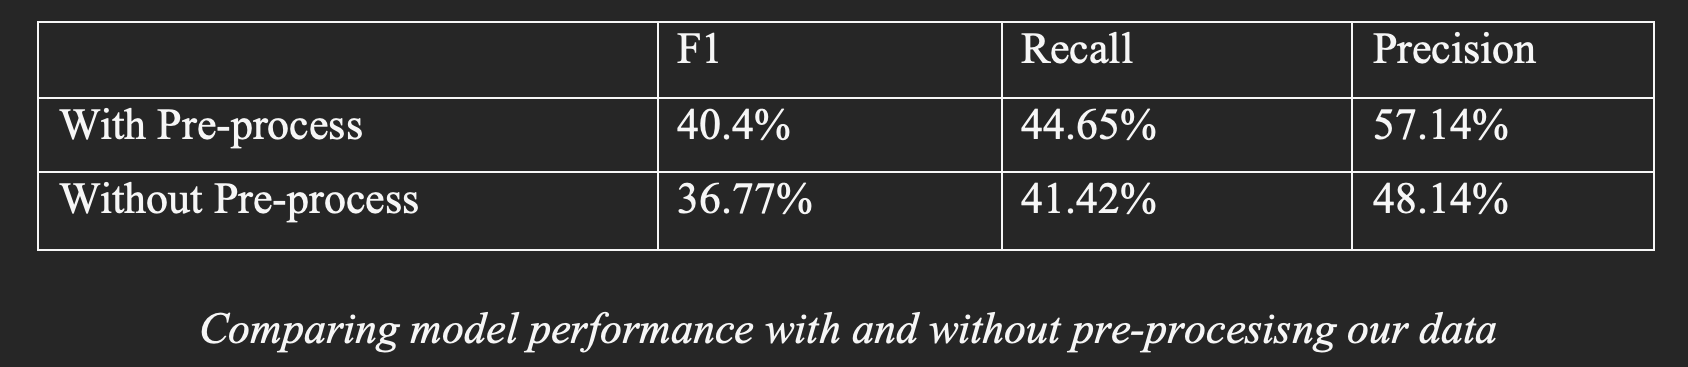

## Answer 2
### As shown below and experimented, I have trained my model on the below mentioned values of MAX_ANT and NEG_RATIO. (400,4) and (100,1.5). I have attached my comparison table able executing and experimenting with these values.

In [ ]:
# the maximum number of candidate antecedents we will give to each of the candidate mentions.
MAX_ANT = 400
# the ratio of negative to postive examples
NEG_RATIO = 4

DEV_DATA = get_data(DEV_PATH, False, True)
TEST_DATA = get_data(TEST_PATH, False, True)
TRAIN_DATA = get_data(TRAIN_PATH, True, True)
print('Trainng with max_ant = 400 and neg_ratio = 4')
train(10)

Trainng with max_ant = 400 and neg_ratio = 4

Starting training epoch 1/10
2775/2775 [==============================] - 83s 30ms/step - loss: 0.4136
Time used for epoch 1: 1 m 22 s
Evaluating on dev set after epoch 1/10:
Average F1 (py): 47.85%
Average precision (py): 51.69%
Average recall (py): 52.88%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 2/10
2775/2775 [==============================] - 84s 30ms/step - loss: 0.3852
Time used for epoch 2: 1 m 24 s
Evaluating on dev set after epoch 2/10:
Average F1 (py): 47.29%
Average precision (py): 51.64%
Average recall (py): 57.33%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 3/10
2775/2775 [==============================] - 83s 30ms/step - loss: 0.3761
Time used for epoch 3: 1 m 22 s
Evaluating on dev set after epoch 3/10:
Average F1 (py): 48.63%
Average precision (py): 52.00%
Average recall (py): 56.77%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 4/10
2775/2775 [========

In [ ]:
# the maximum number of candidate antecedents we will give to each of the candidate mentions.
MAX_ANT = 100
# the ratio of negative to postive examples
NEG_RATIO = 1.5

DEV_DATA = get_data(DEV_PATH, False, True)
TEST_DATA = get_data(TEST_PATH, False, True)
TRAIN_DATA = get_data(TRAIN_PATH, True, True)
train(10)

Trainng with max_ant = 400 and neg_ratio = 4

Starting training epoch 1/10
2775/2775 [==============================] - 82s 29ms/step - loss: 0.3562
Time used for epoch 1: 1 m 21 s
Evaluating on dev set after epoch 1/10:
Average F1 (py): 42.85%
Average precision (py): 48.10%
Average recall (py): 60.25%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 2/10
2775/2775 [==============================] - 83s 30ms/step - loss: 0.3423
Time used for epoch 2: 1 m 22 s
Evaluating on dev set after epoch 2/10:
Average F1 (py): 43.45%
Average precision (py): 48.45%
Average recall (py): 61.74%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 3/10
2775/2775 [==============================] - 83s 30ms/step - loss: 0.3397
Time used for epoch 3: 1 m 22 s
Evaluating on dev set after epoch 3/10:
Average F1 (py): 43.87%
Average precision (py): 49.25%
Average recall (py): 61.41%
Time used for evaluate on dev set: 0 m 2 s

Starting training epoch 4/10
2775/2775 [========

### Result
### I have observed that the maximum F1 score was achieved while using the MAX_ANTs as 400 and the NEG_RATIO as 4. Further I trained my model using MAX_ANTs as 100 and the NEG_RATIO as 1.5 and still achieved better results than my initial model training (MAX_ANTs =250 and the NEG_RATIO =2)

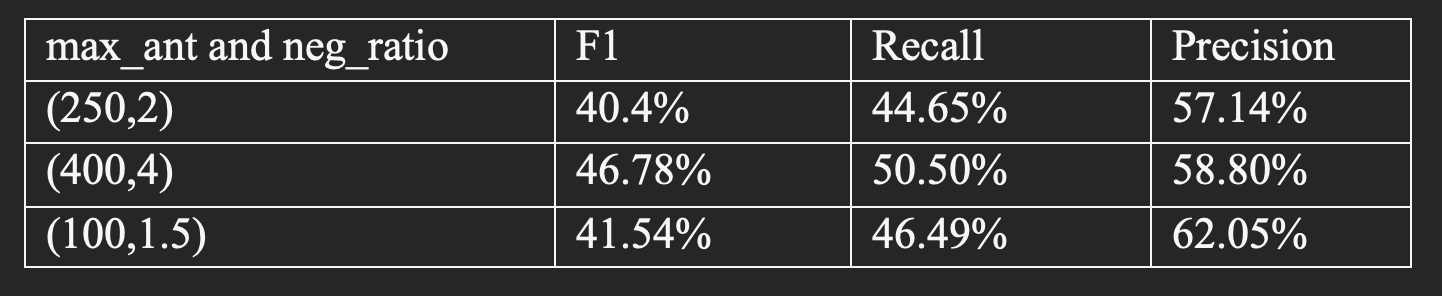


## Answer 3

### The accuracy of this model can be improved by implementing the following techniques:-

1. Further pre-processing our data 
2. Adding extra dense layers to our model
3. Train for a bigger number of epochs
4. Implementing a scheduler: monitoring the loss and varying the learning rate if the loss becomes constant after a certain number of epochs.